This script processes the data for use in the ml models.  This includes imputing missing values and feature engineering.

In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import date, datetime, timedelta
from collections import defaultdict
import seaborn as sns

In [2]:
start_time = datetime.now()

#pull in boxscore data
con = sqlite3.connect('nba.db')

team_basic_boxscores_df = pd.read_sql('select * from team_basic_boxscores', con)
team_advanced_boxscores_df = pd.read_sql('select * from team_advanced_boxscores', con)

team_boxscores_df = team_basic_boxscores_df.merge(team_advanced_boxscores_df, how='inner', on=['GAME_ID', 'TEAM_ID'])

pd.set_option('display.max_columns', None)
team_boxscores_df.head()

,SEASON,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_NAME_y,TEAM_ABBREVIATION_y,TEAM_CITY,MIN_y,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,2021-22,1610612747,LAL,Los Angeles Lakers,0022100002,2021-10-19,LAL vs. GSW,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Lakers,LAL,Los Angeles,240:00,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422
1,2021-22,1610612744,GSW,Golden State Warriors,0022100002,2021-10-19,GSW @ LAL,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Warriors,GSW,Golden State,240:00,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578
2,2021-22,1610612751,BKN,Brooklyn Nets,0022100001,2021-10-19,BKN @ MIL,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Nets,BKN,Brooklyn,240:00,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407
3,2021-22,1610612749,MIL,Milwaukee Bucks,0022100001,2021-10-19,MIL vs. BKN,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Bucks,MIL,Milwaukee,240:00,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593
4,2021-22,1610612754,IND,Indiana Pacers,0022100003,2021-10-20,IND @ CHA,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Pacers,IND,Indiana,240:00,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520


In [3]:
#add home team flag
team_boxscores_df['HOME_TEAM'] = team_boxscores_df['MATCHUP'].str[4] == 'v'

team_boxscores_df['HOME_TEAM']

0         True
1        False
2        False
3         True
4        False
         ...  
56299    False
56300    False
56301     True
56302    False
56303     True
Name: HOME_TEAM, Length: 56304, dtype: bool

In [4]:
team_boxscores_df.columns

Index(['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION_x', 'TEAM_NAME_x', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN_x', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'TEAM_NAME_y',
       'TEAM_ABBREVIATION_y', 'TEAM_CITY', 'MIN_y', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'HOME_TEAM'],
      dtype='object')

In [6]:
team_boxscores_df.drop(columns=['TEAM_ABBREVIATION_x',
                                'TEAM_NAME_x',
                                'MATCHUP',
                                'TEAM_NAME_y',
                                'TEAM_ABBREVIATION_y',
                                'MIN_y'], inplace=True)
team_boxscores_df.rename(columns={'MIN_x':'MIN'}, inplace=True)
team_boxscores_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM
0,2021-22,1610612747,0022100002,2021-10-19,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Los Angeles,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422,True
1,2021-22,1610612744,0022100002,2021-10-19,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Golden State,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578,False
2,2021-22,1610612751,0022100001,2021-10-19,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Brooklyn,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407,False
3,2021-22,1610612749,0022100001,2021-10-19,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Milwaukee,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593,True
4,2021-22,1610612754,0022100003,2021-10-20,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Indiana,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520,False


In [7]:
#check for misssing values
team_boxscores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56304 entries, 0 to 56303
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        56304 non-null  object 
 1   TEAM_ID       56304 non-null  int64  
 2   GAME_ID       56304 non-null  object 
 3   GAME_DATE     56304 non-null  object 
 4   WL            56304 non-null  object 
 5   MIN           56304 non-null  int64  
 6   FGM           56304 non-null  int64  
 7   FGA           56304 non-null  int64  
 8   FG_PCT        56304 non-null  float64
 9   FG3M          56304 non-null  int64  
 10  FG3A          56304 non-null  int64  
 11  FG3_PCT       56304 non-null  float64
 12  FTM           56304 non-null  int64  
 13  FTA           56304 non-null  int64  
 14  FT_PCT        56304 non-null  float64
 15  OREB          56304 non-null  int64  
 16  DREB          56304 non-null  int64  
 17  REB           56304 non-null  int64  
 18  AST           56304 non-nu

In [8]:
#manually calculate estimation of missing rebound percentage stats
oreb_pct_calc = np.empty(len(team_boxscores_df))
dreb_pct_calc = np.empty(len(team_boxscores_df))
reb_pct_calc = np.empty(len(team_boxscores_df))

for i, row in tqdm(team_boxscores_df.iterrows()):
    game_id = row['GAME_ID']
    team_id = row['TEAM_ID']
    
    opp_row = team_boxscores_df[team_boxscores_df['GAME_ID'] == game_id]
    opp_row = opp_row[opp_row['TEAM_ID'] != team_id]
    
    oreb_pct_calc[i] = row['OREB'] / (row['OREB'] + opp_row['DREB'])
    dreb_pct_calc[i] = row['DREB'] / (row['DREB'] + opp_row['OREB'])
    reb_pct_calc[i] = row['REB'] / (row['REB'] + opp_row['REB'])

team_boxscores_df['OREB_PCT_CALC'] = oreb_pct_calc
team_boxscores_df['DREB_PCT_CALC'] = dreb_pct_calc
team_boxscores_df['REB_PCT_CALC'] = reb_pct_calc


#calculate error of calculated stats
team_boxscores_df['OREB_PCT_CALC_DIFF'] = team_boxscores_df['OREB_PCT'] - team_boxscores_df['OREB_PCT_CALC']
team_boxscores_df['DREB_PCT_CALC_DIFF'] = team_boxscores_df['DREB_PCT'] - team_boxscores_df['DREB_PCT_CALC']
team_boxscores_df['REB_PCT_CALC_DIFF'] = team_boxscores_df['REB_PCT'] - team_boxscores_df['REB_PCT_CALC']



56304it [08:40, 108.11it/s]


Text(0, 0.5, 'count')

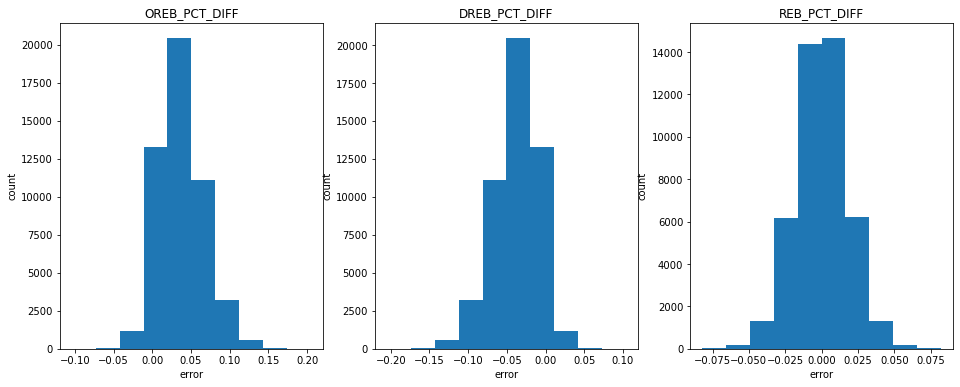

In [9]:
#plot error of calculated rebound percentage stats
fig, axes = plt.subplots(1, 3, figsize=[16, 6])

axes[0].hist(team_boxscores_df['OREB_PCT_CALC_DIFF'])
axes[0].set_title('OREB_PCT_DIFF')
axes[0].set_xlabel('error')
axes[0].set_ylabel('count')

axes[1].hist(team_boxscores_df['DREB_PCT_CALC_DIFF'])
axes[1].set_title('DREB_PCT_DIFF')
axes[1].set_xlabel('error')
axes[1].set_ylabel('count')

axes[2].hist(team_boxscores_df['REB_PCT_CALC_DIFF'])
axes[2].set_title('REB_PCT_DIFF')
axes[2].set_xlabel('error')
axes[2].set_ylabel('count')


In [10]:
#fill in missing rebound percentage stats with calculated values
rebound_pct_cols = ['OREB_PCT', 'DREB_PCT', 'REB_PCT']

for col in rebound_pct_cols:
    team_boxscores_df[col].fillna(value=team_boxscores_df[col + '_CALC'], inplace=True)

team_boxscores_df.drop(columns=['OREB_PCT_CALC_DIFF',
                                'DREB_PCT_CALC_DIFF',
                                'REB_PCT_CALC_DIFF',
                                'OREB_PCT_CALC',
                                'DREB_PCT_CALC',
                                'REB_PCT_CALC'], inplace=True)
team_boxscores_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM
0,2021-22,1610612747,0022100002,2021-10-19,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Los Angeles,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422,True
1,2021-22,1610612744,0022100002,2021-10-19,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Golden State,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578,False
2,2021-22,1610612751,0022100001,2021-10-19,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Brooklyn,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407,False
3,2021-22,1610612749,0022100001,2021-10-19,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Milwaukee,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593,True
4,2021-22,1610612754,0022100003,2021-10-20,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Indiana,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520,False


In [11]:
team_boxscores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56304 entries, 0 to 56303
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        56304 non-null  object 
 1   TEAM_ID       56304 non-null  int64  
 2   GAME_ID       56304 non-null  object 
 3   GAME_DATE     56304 non-null  object 
 4   WL            56304 non-null  object 
 5   MIN           56304 non-null  int64  
 6   FGM           56304 non-null  int64  
 7   FGA           56304 non-null  int64  
 8   FG_PCT        56304 non-null  float64
 9   FG3M          56304 non-null  int64  
 10  FG3A          56304 non-null  int64  
 11  FG3_PCT       56304 non-null  float64
 12  FTM           56304 non-null  int64  
 13  FTA           56304 non-null  int64  
 14  FT_PCT        56304 non-null  float64
 15  OREB          56304 non-null  int64  
 16  DREB          56304 non-null  int64  
 17  REB           56304 non-null  int64  
 18  AST           56304 non-nu

In [12]:
#store actual point spread for each game
game_ids = team_boxscores_df['GAME_ID'].unique()
spreads = np.empty(len(game_ids))

for i, game_id in tqdm(enumerate(game_ids)):
    spread = team_boxscores_df[(team_boxscores_df['GAME_ID']==game_id) &
                               (team_boxscores_df['HOME_TEAM']==True)]['PLUS_MINUS']
    spreads[i] = spread

spreads_df = pd.DataFrame(data={'GAME_ID':game_ids, 'SPREAD':spreads})
spreads_df.head()

28152it [03:36, 129.96it/s]


,GAME_ID,SPREAD
0,0022100002,-7.0
1,0022100001,23.0
2,0022100003,1.0
3,0022100004,-6.0
4,0022100006,-15.0


In [13]:
#change W/L column to 1's and 0's
team_boxscores_df['WL'] = team_boxscores_df['WL'].map({'W':1, 'L':0})

#convert game date to datetime
team_boxscores_df['GAME_DATE'] = pd.to_datetime(team_boxscores_df['GAME_DATE'])


In [14]:
#elo rating helper functions
#credit to rogerfitz

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team

def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    team_rating += 100
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
            
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)

    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    

def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating


In [15]:
def add_elo_ratings(df):
    df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_TEAM'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    elo_col = np.empty(df.shape[0])
    elo_dict = {}
    cur_season = df.iloc[0]['SEASON']
    
    for i, row in tqdm(df.iterrows()):
        
        if i%2 != 0:
            continue
        
        if row['SEASON'] != cur_season:
            cur_season = row['SEASON']
            elo_dict = {team_id:season_reset(elo) for team_id, elo in elo_dict.items()}
        
        away_row = row
        home_row = df.iloc[i+1]
        
        #check both rows are from same game
        if away_row['GAME_ID'] != home_row['GAME_ID']:
            print('game ids do not match')
            print('home game id: ', home_row['GAME_ID'])
            print('away game id: ', away_row['GAME_ID'])
            print('iteration: ', i)
            break
        
        home_team_id = home_row['TEAM_ID']
        away_team_id = away_row['TEAM_ID']
        
        if home_team_id not in elo_dict:
            elo_dict[home_team_id] = 1300
        if away_team_id not in elo_dict:
            elo_dict[away_team_id] = 1300
        
        home_elo = elo_dict[home_team_id]
        away_elo = elo_dict[away_team_id]

        elo_col[i+1] = home_elo
        elo_col[i] = away_elo
        
        home_pts = home_row['PTS']
        away_pts = away_row['PTS']

        home_elo_update, away_elo_update = elo_update(home_pts, away_pts, home_elo, away_elo)
        
        new_home_elo = home_elo + home_elo_update
        new_away_elo = away_elo + away_elo_update
        
        elo_dict[home_team_id] = new_home_elo
        elo_dict[away_team_id] = new_away_elo
    
    df['ELO'] = elo_col
        
    return df
        
    

In [16]:
#add elo ratings
team_boxscores_df = add_elo_ratings(team_boxscores_df)
team_boxscores_df.head()

56304it [00:14, 3783.78it/s]


,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO
0,2000-01,1610612755,0020000001,2000-10-31,1,240,38,66,0.576,3,8,0.375,22,30,0.733,8,29,37,27,10,5,14,24,101,29,Philadelphia,118.5,114.8,81.3,81.8,37.2,33.0,0.711,1.93,22.5,0.258065,0.646000,0.500,16.432,15.9,0.598,0.638,1.0,0.200,86.88,88.0,73.33,88.0,0.819,False,1300.0
1,2000-01,1610612752,0020000001,2000-10-31,0,240,25,70,0.357,3,11,0.273,19,24,0.792,14,23,37,14,6,4,22,30,72,-29,New York,81.3,81.8,118.5,114.8,-37.2,-33.0,0.560,0.64,12.0,0.354000,0.741935,0.500,24.842,25.0,0.379,0.447,1.0,0.201,86.88,88.0,73.33,88.0,0.181,True,1300.0
2,2000-01,1610612739,0020000002,2000-10-31,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,Cleveland,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302000,0.724000,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,False,1300.0
3,2000-01,1610612751,0020000002,2000-10-31,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,New Jersey,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276000,0.698000,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,True,1300.0
4,2000-01,1610612764,0020000003,2000-10-31,0,240,33,72,0.458,4,7,0.571,16,24,0.667,9,35,44,20,6,1,27,28,86,-11,Washington,85.5,87.8,96.5,99.0,-11.0,-11.2,0.606,0.74,15.4,0.279000,0.755000,0.533,26.850,27.6,0.486,0.521,1.0,0.195,100.54,98.0,81.67,98.0,0.415,False,1300.0


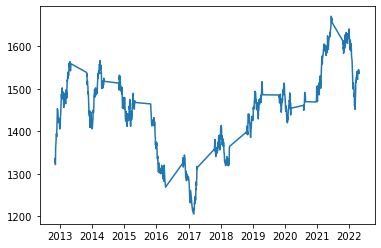

In [18]:
#spot checking to make sure elo ratings make sense
brooklyn_df = team_boxscores_df[team_boxscores_df['TEAM_CITY']=='Brooklyn']
plt.plot(ny_df['GAME_DATE'], brooklyn_df['ELO'])

In [19]:
#take exponentially weighted moving average of stats for each game
num_games = 50
#alpha = 0.05

non_feature_cols = {'SEASON', 'TEAM_ID', 'GAME_ID', 'GAME_DATE', 'HOME_TEAM', 'TEAM_CITY', 'ELO'}
feature_cols = set(team_boxscores_df.columns) - non_feature_cols

weighted_avgs = []

for i, row in tqdm(team_boxscores_df.iterrows()):
    team_id = row['TEAM_ID']
    game_date = row['GAME_DATE']

    temp_df = team_boxscores_df[(team_boxscores_df['TEAM_ID'] == team_id) &
                                (team_boxscores_df['GAME_DATE'] < game_date)].copy()
    temp_df.sort_values(by=['GAME_DATE'], ascending=True, inplace=True)
    temp_df = temp_df.tail(num_games)
    
    if len(temp_df) < num_games:
        continue
    
    temp_df[list(feature_cols)] = temp_df[list(feature_cols)].ewm(span=num_games).mean()
    
    row[list(feature_cols)] = temp_df.iloc[-1]
    
    weighted_avgs.append(row)

weighted_avg_df = pd.DataFrame(weighted_avgs)
weighted_avg_df.reset_index(drop=True, inplace=True)

56304it [14:10, 66.21it/s]


In [20]:
weighted_avg_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO
0,2000-01,1610612760,0020000689,2001-02-05,0.569296,240.928247,36.836888,80.440563,0.459182,5.612216,14.122655,0.410132,19.407179,26.629105,0.727517,12.675174,30.773745,43.448918,21.970119,7.951936,4.438932,16.460783,21.154892,98.693170,-0.463420,Seattle,102.950604,104.527678,103.022662,104.624419,-0.062591,-0.100342,0.597526,1.440166,16.748242,0.318577,0.676615,0.502993,17.126484,17.397431,0.494383,0.536996,1.0,0.198435,95.770107,94.289110,78.574564,94.476716,0.497257,True,1321.428336
1,2000-01,1610612760,0020000704,2001-02-07,0.592322,240.891845,36.964668,80.489445,0.460425,5.569799,14.153324,0.406108,19.092157,26.356868,0.721737,12.681776,30.603610,43.285386,22.164970,8.153636,4.572445,16.378953,20.988219,98.591292,0.181142,Seattle,103.010007,104.556848,102.550784,103.967757,0.463785,0.581096,0.600508,1.455704,16.892223,0.318735,0.682165,0.504069,17.069779,17.334145,0.495311,0.536773,1.0,0.198366,95.543005,94.168661,78.474349,94.348910,0.501037,False,1325.541563
2,2000-01,1610612751,0020000706,2001-02-08,0.313914,240.000000,33.258465,79.768853,0.416080,4.035858,12.788315,0.307910,20.385317,27.197204,0.752287,11.032081,27.881160,38.913241,19.453410,8.658543,4.852835,13.893309,25.108869,90.938105,-6.105939,New Jersey,96.068645,97.024500,102.853167,103.758978,-6.802073,-6.735233,0.588791,1.552587,15.442544,0.280784,0.682815,0.468031,14.663635,14.815820,0.441323,0.495208,1.0,0.198558,94.494865,93.587443,77.989970,93.638356,0.435177,True,1158.589256
3,2000-01,1610612766,0020000707,2001-02-08,0.405933,243.483534,33.042004,78.836785,0.421570,3.881714,11.531323,0.327951,18.881593,25.102434,0.751589,12.757771,31.440882,44.198653,21.893382,7.808816,5.335447,14.803283,21.760708,88.847316,-1.284396,Charlotte,96.635944,96.864739,97.497210,98.528076,-0.861268,-1.666292,0.658086,1.603786,17.206804,0.311172,0.723640,0.515414,16.115708,16.161119,0.446235,0.495746,1.0,0.199187,90.996865,90.377281,75.313878,91.692683,0.500157,True,1299.264022
4,2000-01,1610612743,0020000708,2001-02-08,0.523831,240.848196,36.659073,83.509210,0.438861,6.778872,18.722520,0.365177,18.520931,24.579711,0.749032,12.399352,32.368085,44.767437,24.311075,5.961303,6.745120,13.581550,21.951039,98.617949,-0.770904,Denver,103.245107,104.133345,103.292931,105.325144,-0.043765,-1.193526,0.660030,1.930331,18.259922,0.300379,0.700192,0.502902,14.230635,14.339201,0.479673,0.522728,1.0,0.198908,95.604322,94.263939,78.553205,94.690775,0.491382,False,1312.520179


In [21]:
#add number of rest days
rest_days = np.empty(weighted_avg_df.shape[0])

for i, row in tqdm(weighted_avg_df.iterrows()):
    game_date = row['GAME_DATE']
    team_id = row['TEAM_ID']
    rest_days_df = weighted_avg_df[(weighted_avg_df['TEAM_ID'] == team_id) &
                                     (weighted_avg_df['GAME_DATE'] < game_date)].copy()
    if len(rest_days_df) == 0:
        #assuming earliest game for each team was at the start of the 2000 season, so will assume 4 months rest since their last game of the 1999-2000 season
        rest_days[i] = 120
        continue
    
    rest_days_df.sort_values(by=['GAME_DATE'], ascending=False, inplace=True, ignore_index=True)
    last_game_date = rest_days_df.iloc[0]['GAME_DATE']
    
    delta = game_date - last_game_date
    rest_days[i] = delta.days
    
weighted_avg_df['REST_DAYS'] = rest_days

54804it [04:47, 190.73it/s]


In [22]:
#QA rest days
weighted_avg_df[weighted_avg_df['TEAM_ID']==1610612744].sort_values(by=['GAME_DATE'])

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO,REST_DAYS
37,2000-01,1610612744,0020000741,2001-02-16,0.291391,240.710435,35.942011,85.986697,0.419683,4.411440,14.097705,0.300767,17.617065,24.596537,0.711433,14.720898,30.225044,44.945941,22.233397,9.443064,4.393137,15.941578,21.118740,93.912527,-6.012391,Golden State,95.826449,97.169740,102.902919,103.255202,-7.068686,-6.077433,0.617770,1.493068,16.375004,0.329171,0.707116,0.502725,16.216282,16.473731,0.445606,0.486615,1.0,0.199361,97.318817,96.411490,80.343247,96.638526,0.448115,True,1174.492742,120.0
63,2000-01,1610612744,0020000756,2001-02-18,0.273828,240.682575,35.832774,85.758061,0.419470,4.259250,14.039987,0.289668,17.298611,24.033722,0.717878,14.783331,30.012667,44.795997,22.248788,9.368065,4.235528,16.094596,21.017244,93.223409,-6.378455,Golden State,95.467641,96.865390,102.942983,103.340649,-7.467864,-6.467545,0.620339,1.479126,16.430674,0.332732,0.710559,0.506319,16.460942,16.733239,0.444495,0.485229,1.0,0.199374,96.954629,96.006126,80.005410,96.201584,0.446498,True,1160.076977,2.0
78,2000-01,1610612744,0020000765,2001-02-20,0.263090,240.655807,35.736356,86.120490,0.416801,4.294435,14.096042,0.291367,17.332252,24.098558,0.717385,15.148505,30.162897,45.311402,22.109113,9.320552,4.074228,16.097022,21.148886,93.099400,-6.421238,Golden State,95.313888,96.633239,102.739563,103.152020,-7.419104,-6.511369,0.617970,1.466499,16.303847,0.335177,0.713198,0.507506,16.458557,16.718464,0.441895,0.482792,1.0,0.199450,97.037944,96.123533,80.103237,96.311325,0.443959,False,1150.450621,2.0
108,2000-01,1610612744,0020000780,2001-02-22,0.252773,240.630089,35.975853,86.452697,0.417805,4.219129,13.943949,0.289635,17.259200,24.152317,0.713119,15.196569,30.005782,45.202351,22.467648,9.398685,4.325019,15.967035,20.955505,93.430035,-6.594661,Golden State,95.471272,97.070191,103.408014,103.840203,-7.930428,-6.762890,0.622976,1.503102,16.482169,0.340117,0.707988,0.507872,16.304022,16.591317,0.442392,0.482682,1.0,0.199374,97.074524,96.026117,80.022066,96.229221,0.445116,False,1147.291823,2.0
126,2000-01,1610612744,0020000789,2001-02-23,0.242860,240.605380,35.995208,86.523248,0.417631,4.274295,13.780749,0.301958,17.112980,23.777394,0.720664,14.998918,29.735844,44.734762,22.461581,9.452946,4.227706,15.649528,20.703547,93.377692,-6.236533,Golden State,95.607258,97.130829,103.151889,103.509132,-7.538565,-6.371461,0.622537,1.530872,16.533263,0.335167,0.706404,0.504184,16.019710,16.290653,0.442533,0.482838,1.0,0.199399,96.894892,95.928784,79.940792,96.101247,0.445735,False,1145.949465,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54791,2021-22,1610612744,0042100315,2022-05-26,0.635467,240.000000,41.573992,85.955060,0.485433,13.754511,36.538461,0.378799,16.048148,20.940732,0.769730,9.629456,35.190418,44.819874,27.194882,6.963426,4.512025,14.592000,22.054974,112.950643,3.729263,Golden State,112.937579,114.463011,108.554962,110.852944,4.381624,3.605697,0.654182,1.990630,19.817741,0.267281,0.744485,0.515213,14.524339,14.724991,0.565919,0.595346,1.0,0.197678,100.397252,98.655474,82.212907,98.784558,0.526494,True,1677.956295,2.0
54797,2021-22,1610612744,0042100401,2022-06-02,0.649762,240.000000,41.683801,86.010709,0.486300,13.745730,36.474392,0.379162,16.052396,20.734705,0.779785,9.813122,35.206158,45.019279,27.570861,6.913373,4.458866,14.432729,21.992795,113.165728,3.803365,Golden State,113.639560,115.018976,108.984506,111.359799,4.654101,3.659514,0.660925,2.047305,20.056662,0.270676,0.747691,0.518733,14.412471,14.59617

In [23]:
#reformat so each game is represented by a single row which is the difference between each team's stats
game_ids = weighted_avg_df['GAME_ID'].unique()

revised_rows = []
missing_game_ids = []
missing_game_count = 0

feature_cols.add('ELO')

for game_id in tqdm(game_ids):
    
    home_team_row = weighted_avg_df[(weighted_avg_df['GAME_ID']==game_id) &
                                      (weighted_avg_df['HOME_TEAM']==True)]
    away_team_row = weighted_avg_df[(weighted_avg_df['GAME_ID']==game_id) &
                                      (weighted_avg_df['HOME_TEAM']==False)]
    
    try:
        stats_diff = home_team_row[feature_cols].subtract(np.array(away_team_row[feature_cols]))
        stats_diff[['SEASON','GAME_DATE','GAME_ID','HOME_TEAM_ID','HOME_TEAM_CITY']] = home_team_row[['SEASON',
                                                                                                      'GAME_DATE',
                                                                                                      'GAME_ID',
                                                                                                      'TEAM_ID',
                                                                                                      'TEAM_CITY']]
        revised_rows.append(stats_diff)
    
    except:
        missing_game_ids.append(game_id)
        missing_game_count += 1

final_df = pd.concat(revised_rows)
final_df.head()

print('Number of missing games: ', missing_game_count)

100%|██████████| 27441/27441 [11:40<00:00, 39.17it/s]


Number of missing games:  38


In [24]:
weighted_avg_df[(weighted_avg_df['GAME_ID'].isin(missing_game_ids))].sort_values(by=['GAME_ID'])

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO,REST_DAYS
0,2000-01,1610612760,0020000689,2001-02-05,0.569296,240.928247,36.836888,80.440563,0.459182,5.612216,14.122655,0.410132,19.407179,26.629105,0.727517,12.675174,30.773745,43.448918,21.970119,7.951936,4.438932,16.460783,21.154892,98.693170,-0.463420,Seattle,102.950604,104.527678,103.022662,104.624419,-0.062591,-0.100342,0.597526,1.440166,16.748242,0.318577,0.676615,0.502993,17.126484,17.397431,0.494383,0.536996,1.0,0.198435,95.770107,94.289110,78.574564,94.476716,0.497257,True,1321.428336,120.0
2,2000-01,1610612751,0020000706,2001-02-08,0.313914,240.000000,33.258465,79.768853,0.416080,4.035858,12.788315,0.307910,20.385317,27.197204,0.752287,11.032081,27.881160,38.913241,19.453410,8.658543,4.852835,13.893309,25.108869,90.938105,-6.105939,New Jersey,96.068645,97.024500,102.853167,103.758978,-6.802073,-6.735233,0.588791,1.552587,15.442544,0.280784,0.682815,0.468031,14.663635,14.815820,0.441323,0.495208,1.0,0.198558,94.494865,93.587443,77.989970,93.638356,0.435177,True,1158.589256,120.0
3,2000-01,1610612766,0020000707,2001-02-08,0.405933,243.483534,33.042004,78.836785,0.421570,3.881714,11.531323,0.327951,18.881593,25.102434,0.751589,12.757771,31.440882,44.198653,21.893382,7.808816,5.335447,14.803283,21.760708,88.847316,-1.284396,Charlotte,96.635944,96.864739,97.497210,98.528076,-0.861268,-1.666292,0.658086,1.603786,17.206804,0.311172,0.723640,0.515414,16.115708,16.161119,0.446235,0.495746,1.0,0.199187,90.996865,90.377281,75.313878,91.692683,0.500157,True,1299.264022,120.0
5,2000-01,1610612751,0020000710,2001-02-13,0.346955,240.000000,33.305953,79.656534,0.417297,4.176643,12.769673,0.320434,20.570021,27.331661,0.755054,10.979335,28.114978,39.094313,19.314246,8.717285,4.704143,13.755302,24.977080,91.358571,-5.751242,New Jersey,96.665800,97.640299,103.131653,103.931326,-6.486638,-6.291752,0.583628,1.552179,15.376876,0.279644,0.680417,0.467703,14.537126,14.689682,0.443486,0.497806,1.0,0.198276,94.328549,93.465698,77.888479,93.491939,0.438790,True,1167.075425,5.0
10,2000-01,1610612745,0020000716,2001-02-13,0.506655,241.788232,36.014240,79.684908,0.454667,6.735412,18.368467,0.360629,18.499834,24.284646,0.765161,11.397463,30.610747,42.008210,19.445441,7.048015,4.173067,14.016819,20.932968,97.263726,1.957398,Houston,104.883274,106.069742,102.852732,103.974310,2.032587,2.095526,0.537549,1.473440,15.666537,0.293180,0.700735,0.499718,15.086665,15.284882,0.497750,0.541069,1.0,0.197878,92.221128,91.129690,75.941737,91.842794,0.502797,True,1344.401520,120.0
12,2000-01,1610612743,0020000718,2001-02-13,0.503289,240.814933,36.614819,83.322505,0.439341,6.923599,18.923344,0.368050,18.162233,24.227243,0.743024,12.208420,32.415011,44.623431,24.278068,5.932140,6.540629,13.468040,22.064470,98.315470,-0.978366,Denver,103.209673,103.977389,103.659917,105.380606,-0.450879,-1.404876,0.659978,1.939968,18.308341,0.295813,0.705094,0.503426,14.145279,14.241332,0.481164,0.523028,1.0,0.199015,95.280286,94.129137,78.441003,94.536166,0.488890,True,1307.242818,5.0
15,2000-01,1610612755,0020000723,2001-02-14,0.685720,244.265074,36.088025,79.458498,0.455147,3.654773,10.919326,0.339325,20.462626,27.589683,0.748384,12.493878,32.004993,44.498871,20.471174,8.407225,5.694741,16.030676,20.388116,96.293450,3.830358,Philadelphia,101.271058,102.285522,97.259236,98.235639,4.006635,4.046031,0.565920,1.342747,15.915152,0.315664,0.693519,0.511611,16.846559,17.055868,0.478081,0.526293,1.0,0.198754,93.477651,92.461505,77.051469,94.091415,0.530434,True,1415.377529,1.0
17,2000-01,1610612737,0020000725,2001-02-14,0.305777,240.000000,34.190578,79.538191,0.429890,2.832098,8.612884,0.338147,16.304758,21.279066,0.77

In [25]:
#add spread actuals
final_df = final_df.merge(spreads_df, how='inner', on=['GAME_ID'])
final_df.head()

,TS_PCT,PIE,REB_PCT,PF,STL,E_PACE,WL,FG3M,TM_TOV_PCT,DEF_RATING,BLK,REB,AST_TOV,ELO,E_OFF_RATING,FGA,EFG_PCT,OREB,TOV,E_TM_TOV_PCT,E_USG_PCT,FG3A,FTM,OREB_PCT,FT_PCT,FG3_PCT,PACE_PER40,DREB,PLUS_MINUS,E_NET_RATING,AST,POSS,E_DEF_RATING,FGM,FG_PCT,PACE,OFF_RATING,FTA,PTS,MIN,AST_RATIO,USG_PCT,DREB_PCT,AST_PCT,NET_RATING,SEASON,GAME_DATE,GAME_ID,HOME_TEAM_ID,HOME_TEAM_CITY,SPREAD
0,0.023167,0.083206,-0.013398,-0.062541,1.576017,-2.449737,0.323626,1.993233,-2.180408,-7.013257,-2.854545,-3.600795,0.213268,188.006716,3.773970,-4.688235,0.005291,-2.937968,-2.232552,-1.826209,0.001502,4.137115,3.589673,-0.059732,0.092068,0.054309,-1.376634,-0.662828,8.368020,11.174847,0.246520,-1.209225,-7.402883,-2.643459,-0.009383,-1.651514,1.586411,1.708658,0.295988,0.688165,0.937767,0.0,0.026079,0.054947,8.604764,2000-01,2001-02-13,0020000711,1610612748,Miami,2.0
1,0.005937,0.011904,0.025478,-2.884594,0.294281,-2.964517,-0.005804,0.517092,2.217534,-1.741171,-0.948082,0.134126,-0.399256,28.582841,-0.442295,-5.348476,0.006198,0.529325,1.636991,2.306425,-0.000226,1.247631,1.056761,0.036484,-0.056171,0.019901,-2.050501,-0.395199,0.961978,0.916922,-2.728711,-2.457346,-1.347093,-2.463230,0.000960,-2.460772,-1.035638,2.602118,-3.352608,-0.406002,-1.342768,0.0,0.014510,-0.028727,0.704474,2000-01,2001-02-13,0020000721,1610612757,Portland,21.0
2,0.001986,0.020987,0.034987,-1.362331,-1.308543,2.520978,0.042348,0.248448,1.536961,-1.001472,0.232289,4.579261,-0.173863,31.473465,0.367063,3.011386,0.012298,2.127730,1.869709,1.465914,0.001137,-0.699509,-1.203273,0.038215,-0.049562,0.049078,1.926007,2.451531,1.281232,1.385235,0.284592,2.448046,-0.994680,1.899538,0.011254,2.312433,0.606956,0.091193,2.844252,0.422211,-0.346880,0.0,0.029505,-0.028361,1.606810,2000-01,2001-02-14,0020000726,1610612765,Detroit,19.0
3,-0.007023,-0.025634,0.027347,0.040522,-0.674190,3.718695,-0.091721,-0.949803,-1.320912,7.417952,1.741735,4.460819,0.666391,-53.480896,3.844472,8.729662,0.000015,4.129926,-0.751630,-1.484521,0.000097,-3.257260,0.039705,0.068556,-0.017458,0.009092,2.893589,0.330892,-2.390092,-4.240013,4.838884,3.055300,8.087146,4.384129,0.009539,3.472180,5.131948,0.843280,7.858159,-0.678399,2.037575,0.0,0.009259,0.052569,-2.284216,2000-01,2001-02-15,0020000729,1610612761,Toronto,-7.0
4,0.015543,0.011998,0.017881,-2.908055,-1.648527,-0.267758,0.076961,-1.036224,0.471922,3.199901,0.176510,2.543009,0.028154,76.886842,4.017162,0.095459,0.021606,1.303616,0.367932,0.440270,-0.000051,-4.124378,-0.402837,0.030827,-0.024530,0.049383,-0.163257,1.239393,0.441515,0.711787,0.671229,-0.738167,3.314942,2.353908,0.028173,-0.196528,4.245733,0.517570,3.268755,-0.848107,0.322562,0.0,-0.016127,-0.018852,1.036185,2000-01,2001-02-15,0020000734,1610612760,Seattle,-20.0


In [26]:
final_df.describe()

,TS_PCT,PIE,REB_PCT,PF,STL,E_PACE,WL,FG3M,TM_TOV_PCT,DEF_RATING,BLK,REB,AST_TOV,ELO,E_OFF_RATING,FGA,EFG_PCT,OREB,TOV,E_TM_TOV_PCT,E_USG_PCT,FG3A,FTM,OREB_PCT,FT_PCT,FG3_PCT,PACE_PER40,DREB,PLUS_MINUS,E_NET_RATING,AST,POSS,E_DEF_RATING,FGM,FG_PCT,PACE,OFF_RATING,FTA,PTS,MIN,AST_RATIO,USG_PCT,DREB_PCT,AST_PCT,NET_RATING,HOME_TEAM_ID,SPREAD
count,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,2.736300e+04,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.000000,27363.0,27363.000000,27363.000000,27363.000000,2.736300e+04,27363.000000
mean,-0.000078,-0.000526,-0.000278,0.010223,0.000888,-0.011055,-0.002134,0.003805,0.004564,0.034744,-0.008739,-0.033924,-0.002333,0.410035,-0.034457,-0.027084,-0.000087,-0.014252,0.002549,0.004726,-6.320986e-07,0.015673,-0.006627,-0.000312,0.000020,-0.000046,-0.009287,-0.019673,-0.069436,-0.066171,-0.026058,-0.013037,0.031755,-0.023677,-0.000125,-0.011147,-0.036459,-0.010214,-0.050175,-0.004259,-0.012586,0.0,-0.000158,-0.000309,-0.071233,1.610613e+09,2.935460
std,0.025694,0.047270,0.021426,2.049403,1.262087,3.373936,0.215417,2.175261,1.661193,4.449141,1.200243,2.650602,0.305031,170.960913,4.900514,3.677285,0.026894,1.750274,1.681837,1.614390,6.659633e-04,5.383198,2.625943,0.035616,0.043998,0.033482,2.774448,2.164573,6.476313,7.085713,2.656058,3.358093,4.595743,2.323088,0.021742,3.329345,4.774728,3.406837,6.043325,1.745177,1.659316,0.0,0.024997,0.056592,6.706434,8.616727e+00,13.400021
min,-0.106533,-0.189407,-0.095258,-8.778268,-4.944411,-13.869402,-0.739462,-7.612664,-8.905976,-19.516475,-4.562303,-11.496024,-1.389902,-640.916350,-21.901118,-14.836940,-0.101305,-9.851388,-7.674812,-8.424931,-2.902317e-03,-20.288636,-10.841107,-0.134652,-0.167126,-0.156754,-11.751446,-11.006622,-25.663749,-27.808083,-11.463762,-13.757777,-19.970336,-10.142498,-0.083639,-14.101793,-20.221465,-13.241512,-23.674667,-8.358139,-6.673181,0.0,-0.106571,-0.212697,-26.644387,1.610613e+09,-58.000000
25%,-0.017178,-0.032286,-0.014868,-1.373724,-0.853473,-2.279009,-0.149624,-1.447080,-1.067425,-3.005073,-0.799727,-1.818352,-0.206346,-115.930310,-3.291513,-2.483468,-0.017979,-1.168459,-1.097467,-1.042601,-4.478924e-04,-3.530529,-1.772509,-0.024475,-0.029115,-0.021743,-1.870010,-1.484542,-4.425843,-4.846110,-1.787141,-2.268691,-3.134468,-1.582845,-0.014739,-2.244287,-3.191500,-2.285273,-4.134251,-1.091616,-1.122998,0.0,-0.017021,-0.038114,-4.599498,1.610613e+09,-6.000000
50%,0.000006,-0.000659,-0.000257,0.016532,0.009140,-0.003969,-0.001952,-0.006721,0.003662,0.068735,-0.008551,-0.026658,-0.001461,0.587591,-0.012116,-0.017891,0.000004,-0.012208,-0.000085,0.001760,-1.076347e-06,0.003221,-0.011967,-0.000290,0.000151,0.000026,-0.001104,-0.011000,-0.082183,-0.099159,-0.017937,-0.019133,0.071669,-0.006089,-0.000239,-0.001266,-0.034175,-0.034571,-0.026606,0.000000,-0.011248,0.0,-0.000011,-0.000285,-0.082033,1.610613e+09,4.000000
75%,0.017014,0.030986,0.014305,1.383381,0.843915,2.267082,0.143991,1.453389,1.089559,3.089647,0.778684,1.740376,0.198696,116.716203,3.281820,2.419334,0.017823,1.145046,1.102287,1.058478,4.460737e-04,3.564568,1.748813,0.023670,0.029370,0.021779,1.854378,1.439332,4.311461,4.735950,1.711013,2.249809,3.176557,1.531196,0.014429,2.225765,3.201184,2.268331,3.970813,1.072340,1.093512,0.0,0.016807,0.037355,4.460297,1.610613e+09,12.000000
max,0.095629,0.174445,0.089168,10.362668,5.081039,12.843759,0.764655,7.939841,7.666655,20.506185,4.713761,10.848249,1.341459,673.331596,20.596978,14.499165,0.100277,9.440284,7.034327,7.427146,2.523252e-03,21.398065,10.256486,0.145972,0.164778,0.168618,10.773073,10.714043,24.008318

array([[<AxesSubplot:title={'center':'TS_PCT'}>,
        <AxesSubplot:title={'center':'PIE'}>,
        <AxesSubplot:title={'center':'REB_PCT'}>,
        <AxesSubplot:title={'center':'PF'}>,
        <AxesSubplot:title={'center':'STL'}>,
        <AxesSubplot:title={'center':'E_PACE'}>,
        <AxesSubplot:title={'center':'WL'}>],
       [<AxesSubplot:title={'center':'FG3M'}>,
        <AxesSubplot:title={'center':'TM_TOV_PCT'}>,
        <AxesSubplot:title={'center':'DEF_RATING'}>,
        <AxesSubplot:title={'center':'BLK'}>,
        <AxesSubplot:title={'center':'REB'}>,
        <AxesSubplot:title={'center':'AST_TOV'}>,
        <AxesSubplot:title={'center':'ELO'}>],
       [<AxesSubplot:title={'center':'E_OFF_RATING'}>,
        <AxesSubplot:title={'center':'FGA'}>,
        <AxesSubplot:title={'center':'EFG_PCT'}>,
        <AxesSubplot:title={'center':'OREB'}>,
        <AxesSubplot:title={'center':'TOV'}>,
        <AxesSubplot:title={'center':'E_TM_TOV_PCT'}>,
        <AxesSubplot:title={

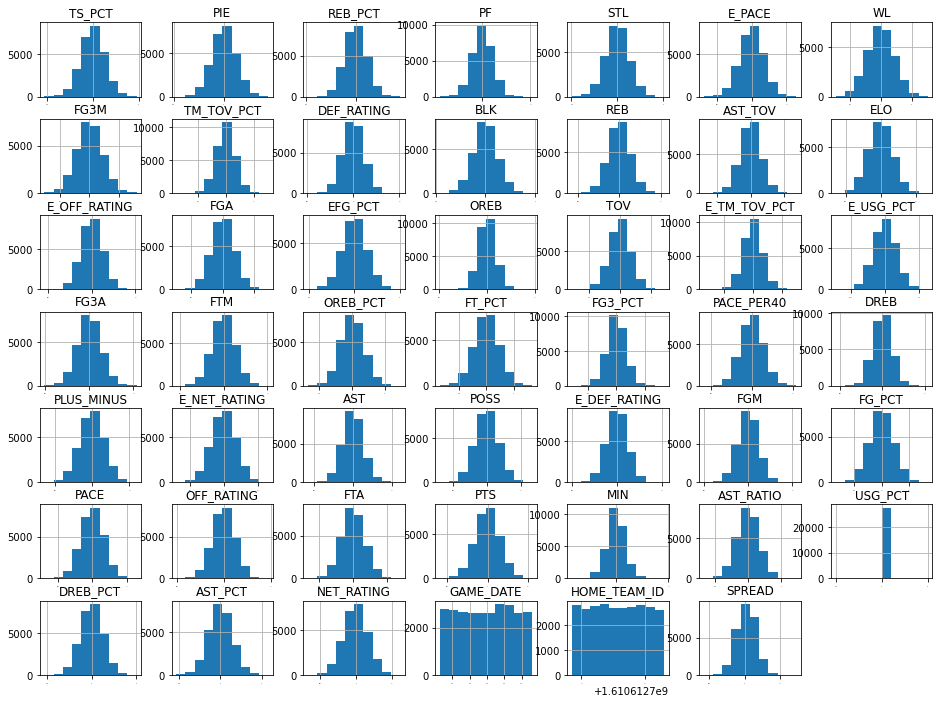

In [27]:
#check distribution of data
final_df.hist(figsize=(16,12), xlabelsize=0)

In [28]:
def check_missing_vals(df):
    cols_w_missing_vals = []
    for col in df.columns:
        if df[col].isna().sum() != 0:
            cols_w_missing_vals.append(col)
    return cols_w_missing_vals

In [29]:
check_missing_vals(final_df)

[]

In [30]:
final_df.to_csv('data_elo.csv')
print('Data converted to csv')
print('Runtime : ', datetime.now() - start_time)

Data converted to csv
Runtime :  0:43:47.385784
